In [27]:
# Importando os pacotes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump, load

import functions as f

from DataProcesser import DataProcesser

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

from hpsklearn import HyperoptEstimator, xgboost_classification, knn, random_forest, svc_sigmoid, sgd, gaussian_nb
from hyperopt import tpe

In [2]:
# Importando o dataset de treinamento
dataset = pd.read_csv('../datasets/treino.csv')

In [3]:
dataset_x = dataset.drop(['id', 'classe'], axis=1)
dataset_y = dataset['classe']

In [4]:
dp_dataset = DataProcesser(X=dataset_x, y=dataset_y)

In [5]:
dataset_processado = dp_dataset.process_train_data(with_target_column=False)

In [6]:
dataset_processado.head(10)

,num_gestacoes,glicose,pressao_sanguinea,grossura_pele,insulina,bmi,indice_historico,idade,num_gestacoes_miss,glicose_miss,pressao_sanguinea_miss,grossura_pele_miss,insulina_miss,bmi_miss,indice_historico_miss,idade_miss,missing_total
0,6.00,148.0,72.000000,35.000000,207.514563,33.600000,0.627,50,0,0,0,0,1,0,0,0,1
1,1.00,85.0,66.000000,29.000000,126.649038,26.600000,0.351,31,0,0,0,0,1,0,0,0,1
2,8.00,183.0,64.000000,33.014286,207.514563,23.300000,0.672,32,0,0,0,1,1,0,0,0,2
3,1.00,89.0,66.000000,23.000000,94.000000,28.100000,0.167,21,0,0,0,0,0,0,0,0,0
4,5.68,137.0,40.000000,35.000000,168.000000,43.100000,2.288,33,1,0,0,0,0,0,0,0,1
5,5.00,116.0,74.000000,27.063158,126.649038,25.600000,0.201,30,0,0,0,1,1,0,0,0,2
6,3.00,78.0,50.000000,32.000000,88.000000,31.000000,0.248,26,0,0,0,0,0,0,0,0,0
7,10.00,115.0,70.493369,27.063158,126.649038,35.300000,0.134,29,0,0,1,1,1,0,0,0,3
8,2.00,197.0,70.000000,45.000000,543.000000,30.500000,0.158,53,0,0,0,0,0,0,0,0,0
9,8.00,125.0,96.000000,33.014286,207.514563,35.556522,0.232,54,0,0,0,1,1,1,0,0,3


In [7]:
x_treino, x_validacao, y_treino, y_validacao = train_test_split(dataset.drop(['id', 'classe'], axis=1), dataset.classe, test_size=0.25, random_state=42)

In [8]:
dp_treino = DataProcesser(X=x_treino, y=y_treino)
mean_dict = dp_treino.get_means_by_column()

In [9]:
dp_validacao = DataProcesser(X=x_validacao, mean_dict=mean_dict)

In [10]:
x_treino_processado = dp_treino.process_train_data(with_target_column=False)
x_validacao_processado = dp_validacao.process_test_data()

In [19]:
n_evals = 50
trial_timeout = 300

random_forest_estimator = HyperoptEstimator(classifier=random_forest('rf'),
                                            algo=tpe.suggest,
                                            max_evals=n_evals,
                                            trial_timeout=trial_timeout)

xgboost_estimator = HyperoptEstimator(classifier=xgboost_classification('xgb'),
                                      algo=tpe.suggest,
                                      max_evals=n_evals,
                                      trial_timeout=trial_timeout)

knn_estimator = HyperoptEstimator(classifier=knn('knn'),
                                  algo=tpe.suggest,
                                  max_evals=n_evals,
                                  trial_timeout=trial_timeout)

svc_estimator = HyperoptEstimator(classifier=svc_sigmoid('svc'),
                                  algo=tpe.suggest,
                                  max_evals=n_evals,
                                  trial_timeout=trial_timeout)

sgd_estimator = HyperoptEstimator(classifier=sgd('sgd'),
                                  algo=tpe.suggest,
                                  max_evals=n_evals,
                                  trial_timeout=trial_timeout)  

gaussian_nb_estimator = HyperoptEstimator(classifier=gaussian_nb('gnb'),
                                          algo=tpe.suggest,
                                          max_evals=n_evals,
                                          trial_timeout=trial_timeout)                                                                       

In [20]:
estimators_list = [random_forest_estimator, xgboost_estimator, knn_estimator, svc_estimator, sgd_estimator, gaussian_nb_estimator]
names = ['rf', 'xgb', 'knn', 'svc', 'sgd', 'gnb']

models_dict = {}
score_dict = {}


In [21]:
for estimator, name in zip(estimators_list, names):
    print(f'\nsearching {name} best parameters and fitting de model...')

    estimator.fit(x_treino_processado, y_treino)
    estimator.retrain_best_model_on_full_data(x_treino_processado, y_treino)

    best_model = estimator.best_model()['learner']

    models_dict[name] = best_model
    score_dict[name] = estimator.score(x_validacao_processado, y_validacao)

30/30 [00:02<00:00,  2.92s/trial, best loss: 0.07777777777777772]
100%|██████████| 50/50 [00:02<00:00,  2.52s/trial, best loss: 0.07777777777777772]
[12:05:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
c:\Users\Admin\Documents\samuel\github\ia-doctor\venv\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Admin\Documents\samuel\github\ia-doctor\venv\lib\s

In [22]:
best_model_of_all = models_dict[max(score_dict, key=score_dict.get)]

In [23]:
score_dict

{'rf': 0.7333333333333333,
 'xgb': 0.6866666666666666,
 'knn': 0.6733333333333333,
 'svc': 0.72,
 'sgd': 0.6266666666666667,
 'gnb': 0.48}

In [24]:
models_dict

{'rf': RandomForestClassifier(criterion='entropy', max_depth=3,
                        max_features=0.647741085311123, n_estimators=41,
                        n_jobs=1, random_state=4, verbose=False),
 'xgb': XGBClassifier(base_score=0.5, booster='gbtree',
               colsample_bylevel=0.5356517688954909, colsample_bynode=1,
               colsample_bytree=0.8423971924145178, gamma=0.49071005254865785,
               gpu_id=-1, importance_type='gain', interaction_constraints='',
               learning_rate=0.41942300268938953, max_delta_step=0, max_depth=9,
               min_child_weight=23, missing=nan, monotone_constraints='()',
               n_estimators=400, n_jobs=1, num_parallel_tree=1, random_state=4,
               reg_alpha=0.0021476443698763502, reg_lambda=1.472127511711466,
               scale_pos_weight=1, seed=4, subsample=0.6334327930003032,
               tree_method='exact', validate_parameters=1, verbosity=None),
 'knn': KNeighborsClassifier(metric='manhattan'

In [25]:
np.mean(cross_val_score(estimator=best_model_of_all,
                        X=dataset_processado,
                        y=dataset_y,
                        scoring='accuracy',
                        cv=3))

0.88

In [26]:
best_model_of_all.fit(dataset_processado, dataset_y)

RandomForestClassifier(criterion='entropy', max_depth=3,
                       max_features=0.647741085311123, n_estimators=41,
                       n_jobs=1, random_state=4, verbose=False)

In [29]:
dump(best_model_of_all, 'models/i_doctor.joblib')

['models/i_doctor.joblib']

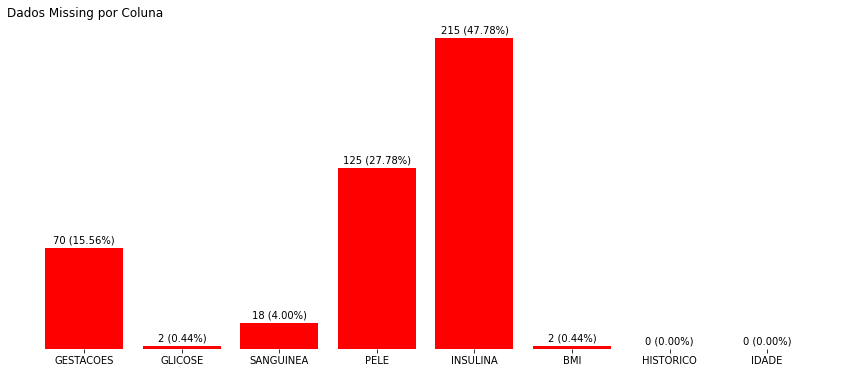

In [7]:
f.display_missing_barchart(dataframe=x_treino, columns=x_treino.columns, missing_value=0)

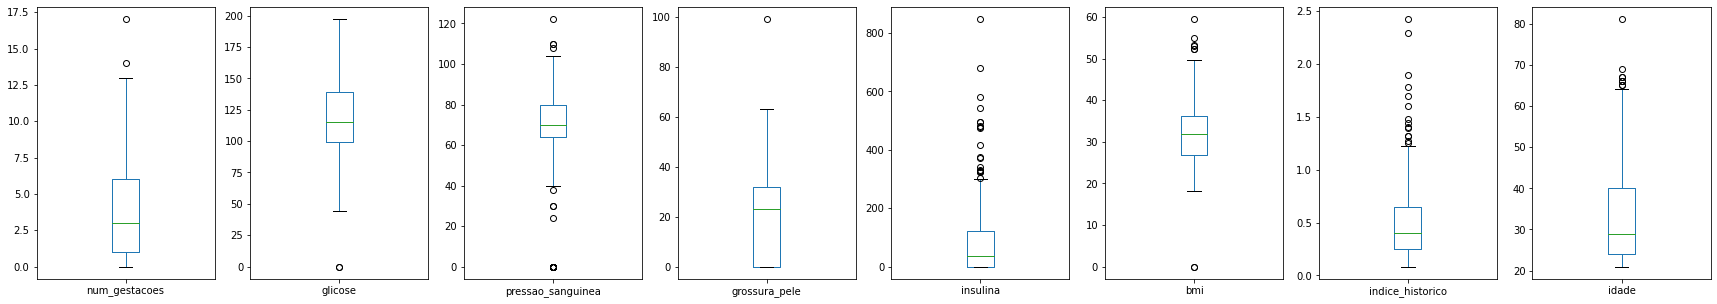

In [8]:
f.display_distribution_boxchart(dataframe=x_treino, columns=x_treino.columns)

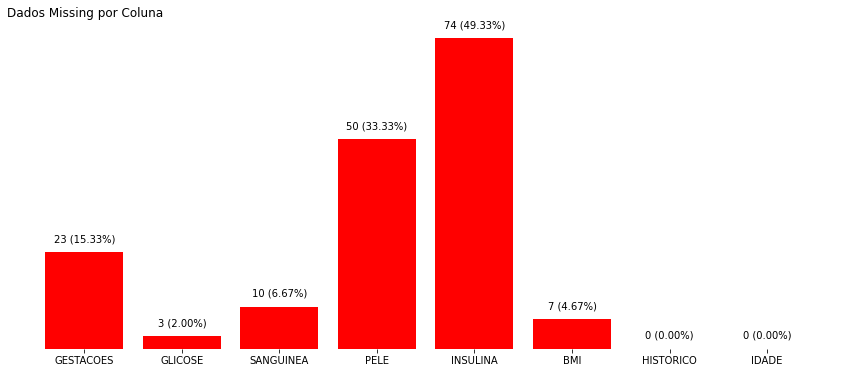

In [9]:
f.display_missing_barchart(dataframe=x_teste, columns=x_teste.columns, missing_value=0)

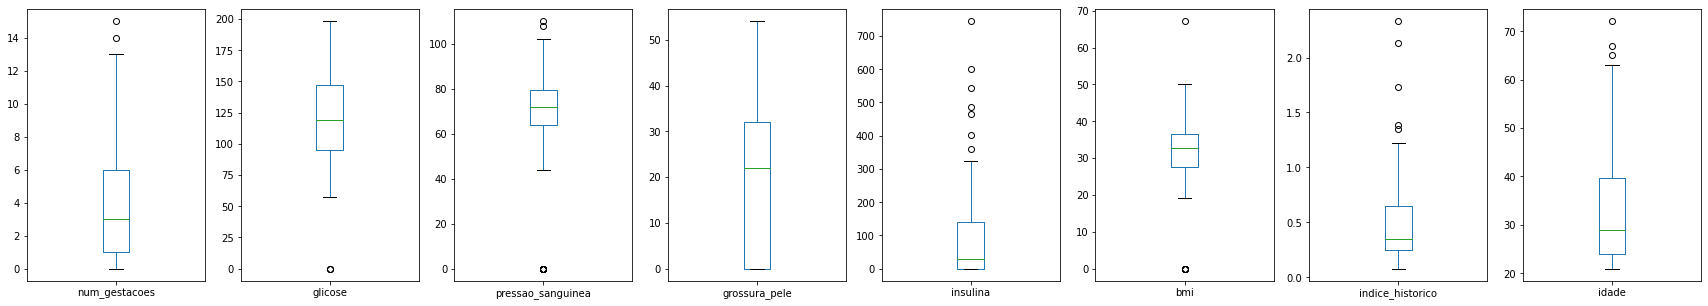

In [10]:
f.display_distribution_boxchart(dataframe=x_teste, columns=x_teste.columns)